# NPP NUCAPS Profile 2028 UTC 1 July 2014

In [4]:
from __future__ import division
import matplotlib.pyplot as plt
import numpy as np
import math
from six import StringIO
from six import BytesIO
import pandas as pd

'''
NPP NUCAPS Profile at 2014-07-01 20:28 UTC 
Retrieval Location: Lat: 39.38N Lon: 119.57W
'''

nucaps_prof = "npp_nucaps_2028_data.txt"
prof_data = np.loadtxt(nucaps_prof, usecols=range(0, 4), dtype='f', unpack=True)
print(prof_data)
pressure_mb = np.flip(prof_data[0,:])
print(pressure_mb)
height_km = np.flip(prof_data[1,:])
print(height_km)
temperature_k = np.flip(prof_data[2,:])
print(temperature_k)
temperature_c = temperature_k - 273.15
print(temperature_c)
mixrat = np.flip(prof_data[3,:])
print(mixrat)
height_m = height_km * 1000
print(height_m,len(height_m))
"""
Saturation mixing ratio (satmixrat) and relative humidity (RH) are derived from the Magnus formula (Huang et al. 2023), 
e = 6.11 * exp((17.62 * T) / (T + 243.12)), and Haltiner and Martin (1957) equations 3-6 and 3-11.
"""
satmixrat_tgt0 = (1000*0.622)*(6.11*(np.exp((17.62*temperature_c[0:11])/(243.12+temperature_c[0:11]))))/(pressure_mb[0:11]-(6.11*(np.exp((17.62*temperature_c[0:11])/(temperature_c[0:11]+243.12)))))
print("Sat_mix_ratio for T(C) > 0 = ",satmixrat_tgt0)
satmixrat_tlt0 = (1000*0.622)*(6.11*(np.exp((22.46*temperature_c[11:46])/(272.62+temperature_c[11:46]))))/(pressure_mb[11:46]-(6.11*(np.exp((22.46*temperature_c[11:46])/(temperature_c[11:46]+272.62)))))
print("Sat_mix_ratio for T(C) < 0 = ",satmixrat_tlt0)
satmixrat= np.concatenate((satmixrat_tgt0, satmixrat_tlt0))
print("Sat_mix_ratio for all T(C) = ",satmixrat)
RH = 100*(mixrat/satmixrat)
print("RH: ", RH)
dewpoint_c = temperature_c - (((100-RH)/5)*((temperature_k/300)**2)) - 0.00135*((RH-84)**2) + 0.35
L_vapor = 2500
thetae = (273.15 + temperature_c)*((1000/pressure_mb)**0.286)+(3 * (RH * (3.884266 * 10**
         ((7.5 * temperature_c)/(237.7 + temperature_c)))/100))
wetbulb = temperature_c*(np.arctan(0.151977*((RH+8.313659)**0.5))) + (np.arctan(temperature_c+RH)) - (np.arctan(RH-1.676331))+((0.00391838*(RH**1.5))*(np.arctan(0.023101*RH))) - 4.686035
WBD = temperature_c - wetbulb
thetaw = thetae - (L_vapor*mixrat)
"""
Approximation for virtual temperature (tempvirt) is derived from Wallace and Hobbs (2006) equation 3.60.
"""
tempvirt = temperature_k*(1+(0.61*(mixrat)))
tempvirt_c = tempvirt - 273.15
print("Virtual Temperature (C) = ",tempvirt_c)
tempvirt_exc = tempvirt_c - temperature_c
idx_pup = np.where(pressure_mb == 617.5)
idx_plo = np.where(pressure_mb == 802.3)
print("PUP idx = ", idx_pup)
print("PLO idx = ", idx_plo)
Z_upper = height_km[idx_pup]
Z_lower = height_km[idx_plo]
T_sfc = temperature_k[idx_plo]
T_top = temperature_k[idx_pup]
Te_sfc = thetae[idx_plo]
Te_top = thetae[idx_pup]
Tv_sfc = tempvirt_c[idx_plo]
Tv_top = tempvirt_c[idx_pup]
wetbulb_sfc = wetbulb[idx_plo]
wetbulb_top = wetbulb[idx_pup]
thetaw_sfc = thetaw[idx_pup]
delta_z = 2000
delta_zkm = 2.0
gamma = (T_sfc - T_top)/(delta_zkm)
gamma_Te = (Te_sfc - Te_top)/(Z_lower - Z_upper)
gamma_Tv = (Tv_sfc - Tv_top)/(delta_zkm)
gamma_wb = (wetbulb_sfc - wetbulb_top)/(delta_zkm)

print("")
print("Gamma = ", gamma)
if gamma > 4.8 and gamma <= 9.8:
    print("Conditional Instability") 
elif gamma > 9.8:
    print("Absolute Instability")
print("Theta-e Gamma = ", gamma_Te)
if gamma_Te < 0:
    print("Theta-e lapse rate is negative: potential instability")    
print("Tv Gamma = ", gamma_Tv)
print("Wetbulb Gamma = ", gamma_wb)
if gamma_wb > 4.8:
    print("Potential Instability")    
P_level_upper = pressure_mb[idx_pup]
P_level_lower = pressure_mb[idx_plo]
Z_upper = height_km[idx_pup]
Z_lower = height_km[idx_plo]
T_upper = temperature_c[idx_pup]
T_lower = temperature_c[idx_plo]
Tv_upper = tempvirt_c[idx_pup]
Tv_lower = tempvirt_c[idx_plo]
TD_upper = dewpoint_c[idx_pup]
TD_lower = dewpoint_c[idx_plo]
CAPE = 214.93
 
def MWPI(P_level_upper, P_level_lower, Z_upper, Z_lower, T_upper, T_lower, TD_upper, TD_lower, CAPE):
        gamma = (T_lower - T_upper)/(Z_upper - Z_lower)
        DD_upper = T_upper - TD_upper
        DD_lower = T_lower - TD_lower
        DDD = DD_lower - DD_upper
        MWPI = (CAPE/1000) + (gamma/5) + (DDD/5)
        WGP = (1.1 * (MWPI**2)) + (-3.8*MWPI) + 43.7
        return MWPI, WGP    
MWPI, WGP  = MWPI(P_level_upper, P_level_lower, Z_upper, Z_lower, T_upper, T_lower, TD_upper, TD_lower, CAPE)    
print("")
print("MWPI = ", MWPI)
print("MWPI WGP (kt) = ", WGP)

def MWPI_Tv(P_level_upper, P_level_lower, Z_upper, Z_lower, Tv_upper, Tv_lower, TD_upper, TD_lower, CAPE):
        gamma = (Tv_lower - Tv_upper)/(Z_upper - Z_lower)
        DD_upper = Tv_upper - TD_upper
        DD_lower = Tv_lower - TD_lower
        DDD = DD_lower - DD_upper
        MWPI_Tv = (CAPE/1000) + (gamma/5) + (DDD/5)
        WGP_Tv = (1.1 * (MWPI**2)) + (-3.8*MWPI) + 43.7
        return MWPI_Tv, WGP_Tv
MWPI_Tv, WGP_Tv  = MWPI_Tv(P_level_upper, P_level_lower, Z_upper, Z_lower, Tv_upper, Tv_lower, TD_upper, TD_lower, CAPE)    
print("")
print("MWPI from Virtual Temperature:")
print("MWPI = ", MWPI_Tv)
print("MWPI WGP (kt) = ", WGP_Tv)

def Haines_H(T_UP, T_LO, TD_LO):
    Tdiff = T_LO - T_UP
    print("Tdiff = ", Tdiff)
    DD_LO = T_LO - TD_LO
    print("DD_LO = ", DD_LO)
    if Tdiff < 17:
        ST = 1
    elif Tdiff >= 17 and Tdiff <= 21:
        ST = 2
    else:
        ST = 3   
    if DD_LO < 14:
        MT = 1
    elif DD_LO >= 14 and DD_LO <= 20:
        MT = 2
    else:    
        MT = 3
    HI = ST + MT    
    print("ST = ", ST)
    print("MT = ", MT)
    print("HI = ", HI)
    return HI
 
def Haines_M(T_UP, T_LO, TD_LO):
    Tdiff = T_LO - T_UP
    print("Tdiff = ", Tdiff)
    DD_LO = T_LO - TD_LO
    print("DD_LO = ", DD_LO)
    if Tdiff < 5:
        ST = 1
    elif Tdiff >= 5 and Tdiff <= 10:
        ST = 2
    else:
        ST = 3   
    if DD_LO < 5:
        MT = 1
    elif DD_LO >= 5 and DD_LO <= 12:
        MT = 2
    else:    
        MT = 3
    HI = ST + MT    
    print("ST = ", ST)
    print("MT = ", MT)
    print("HI = ", HI)
    return HI
        
def C_Haines(T_UP, T_LO, TD_LO):
    Tdiff = T_LO - T_UP
    print("Tdiff = ", Tdiff)
    DD_LO = T_LO - TD_LO
    print("DD_LO = ", DD_LO)
    if DD_LO >30:
        DD_LO=30
    CA=((T_LO-T_UP)/2)-2
    CB=((DD_LO)/3)-1
    if CB>5:
        CB=5+(CB-5)/2
    CH=CA+CB
    return CH
         
idx_pup_high = np.where(pressure_mb == 496.6)
idx_plo_high = np.where(pressure_mb == 706.5)
T_UP = temperature_c[idx_pup_high]
print("T_UP = ", T_UP)
T_LO = temperature_c[idx_plo_high]
print("T_LO = ", T_LO)
TD_LO = dewpoint_c[idx_plo_high]
print("TD_LO = ", TD_LO)

idx_pup_mid = np.where(pressure_mb == 617.5)
idx_plo_mid = np.where(pressure_mb == 802.3)
T_UP_mid = temperature_c[idx_pup_mid]
print("T_UP_mid = ", T_UP_mid)
T_LO_mid = temperature_c[idx_plo_mid]
print("T_LO_mid = ", T_LO_mid)
TD_LO_mid = dewpoint_c[idx_plo_mid]
print("TD_LO_mid = ", TD_LO_mid)
    
HI_M = Haines_M(T_UP_mid, T_LO_mid, TD_LO_mid)
HI_H = Haines_H(T_UP, T_LO, TD_LO)
CH = Haines_M(T_UP_mid, T_LO_mid, TD_LO_mid)
    
print("Haines Index MID = ", HI_M)
print("Haines Index HIGH = ", HI_H)
print("C-Haines Index = ", CH)

mydata=dict(zip(('hght','pres','temp','dwpt','thtae','thetaw','wetbulb','depression','tempvirt','tempvirt_exc'),(height_m,pressure_mb,temperature_c,dewpoint_c,thetae,thetaw,wetbulb,WBD,tempvirt_c,tempvirt_exc)))
print(mydata)
df_ret = pd.DataFrame.from_dict(mydata)
print(df_ret)
wdir = []
wspd = []
wval = 0
data_len = len(df_ret)
print("DF Length = ", data_len)
for i in range(data_len):
    wdir.append(wval)
    wspd.append(wval)
print("wdir, wspd: ", wdir, wspd)
data_sharppy=dict(zip(('pres','hght','temp','dwpt'),(pressure_mb, height_m, temperature_c, dewpoint_c)))
print(data_sharppy)
df_sharppy = pd.DataFrame.from_dict(data_sharppy)
print(df_sharppy)
df_sharppy = df_sharppy[['pres', 'hght', 'temp', 'dwpt']]
print(df_sharppy)
df_sharppy_wind =df_sharppy.assign(wdir = wdir, wspd = wspd)
print(df_sharppy_wind)
print("")
print("Sharppy formatted retrieval: ")
print("")
print(df_sharppy_wind.to_string(header=False, index=False, formatters={"pres": "  {:.2f},  ".format, "hght": "{:.2f},  ".format,
                                                                       "temp": "{:.2f},  ".format, "dwpt": "{:.2f},  ".format,
                                                                       "wdir": "{:.2f},  ".format, "wspd": "{:.2f} ".format}))
print("")
print("Sounding profile with virtual temperature")
print("")
data_sharppy=dict(zip(('pres','hght','tempvirt','dwpt'),(pressure_mb, height_m, tempvirt_c, dewpoint_c)))
print(data_sharppy)
df_sharppy = pd.DataFrame.from_dict(data_sharppy)
print(df_sharppy)
df_sharppy = df_sharppy[['pres', 'hght', 'tempvirt', 'dwpt']]
print(df_sharppy)
df_sharppy_wind =df_sharppy.assign(wdir = wdir, wspd = wspd)
print(df_sharppy_wind)
print("")
print("Sharppy formatted retrieval: ")
print("")
print(df_sharppy_wind.to_string(header=False, index=False, formatters={"pres": "  {:.2f},  ".format, "hght": "{:.2f},  ".format,
                                                                       "tempvirt": "{:.2f},  ".format, "dwpt": "{:.2f},  ".format,
                                                                       "wdir": "{:.2f},  ".format, "wspd": "{:.2f} ".format}))
print("")

mydata=dict(zip(('hght','pres','temp','dwpt','thtae','thetaw','wetbulb','depression','tempvirt','tempvirt_exc'),(height_m,pressure_mb,temperature_c,dewpoint_c,thetae,thetaw,wetbulb,WBD,tempvirt_c,tempvirt_exc)))
print(mydata)
df_ret = pd.DataFrame.from_dict(mydata)
print(df_ret)
wdir = []
wspd = []
wval = -9999.00
data_len = len(df_ret)
print("DF Length = ", data_len)
for i in range(data_len):
    wdir.append(wval)
    wspd.append(wval)
print("wdir, wspd: ", wdir, wspd)
data_sharppy=dict(zip(('pres','hght','temp','dwpt'),(pressure_mb, height_m, temperature_c, dewpoint_c)))
print(data_sharppy)
df_sharppy = pd.DataFrame.from_dict(data_sharppy)
print(df_sharppy)
df_sharppy = df_sharppy[['pres', 'hght', 'temp', 'dwpt']]
print(df_sharppy)
df_sharppy_wind =df_sharppy.assign(wdir = wdir, wspd = wspd)
print(df_sharppy_wind)
print("")
print("Sharppy formatted retrieval: ")
print("")
print(df_sharppy_wind.to_string(header=False, index=False, formatters={"pres": "  {:.2f},  ".format, "hght": "{:.2f},  ".format,
                                                                       "temp": "{:.2f},  ".format, "dwpt": "{:.2f},  ".format,
                                                                       "wdir": "{:.2f},  ".format, "wspd": "{:.2f} ".format}))
print("")
print("Sounding profile with virtual temperature")
print("")
data_sharppy=dict(zip(('pres','hght','tempvirt','dwpt'),(pressure_mb, height_m, tempvirt_c, dewpoint_c)))
print(data_sharppy)
df_sharppy = pd.DataFrame.from_dict(data_sharppy)
print(df_sharppy)
df_sharppy = df_sharppy[['pres', 'hght', 'tempvirt', 'dwpt']]
print(df_sharppy)
df_sharppy_wind =df_sharppy.assign(wdir = wdir, wspd = wspd)
print(df_sharppy_wind)
print("")
print("Sharppy formatted retrieval: ")
print("")
print(df_sharppy_wind.to_string(header=False, index=False, formatters={"pres": "  {:.2f},  ".format, "hght": "{:.2f},  ".format,
                                                                       "tempvirt": "{:.2f},  ".format, "dwpt": "{:.2f},  ".format,
                                                                       "wdir": "{:.2f},  ".format, "wspd": "{:.2f} ".format}))
print("")

[[1.0300e+02 1.1020e+02 1.1770e+02 1.2560e+02 1.3380e+02 1.4230e+02
  1.5120e+02 1.6040e+02 1.7000e+02 1.8000e+02 1.9030e+02 2.0090e+02
  2.1200e+02 2.2340e+02 2.3520e+02 2.4740e+02 2.5990e+02 2.7290e+02
  2.8620e+02 3.0000e+02 3.1410e+02 3.2860e+02 3.4360e+02 3.5890e+02
  3.7470e+02 3.9080e+02 4.0740e+02 4.2440e+02 4.4180e+02 4.5970e+02
  4.7790e+02 4.9660e+02 5.1570e+02 5.3520e+02 5.5510e+02 5.7550e+02
  5.9630e+02 6.1750e+02 6.3910e+02 6.6110e+02 6.8360e+02 7.0650e+02
  7.2980e+02 7.5360e+02 7.7770e+02 8.0230e+02]
 [1.6000e+01 1.5500e+01 1.5300e+01 1.4800e+01 1.4500e+01 1.4000e+01
  1.3500e+01 1.3200e+01 1.2800e+01 1.2500e+01 1.2000e+01 1.1800e+01
  1.1500e+01 1.1000e+01 1.0750e+01 1.0500e+01 1.0100e+01 9.8000e+00
  9.5000e+00 9.2000e+00 8.9000e+00 8.5000e+00 8.2500e+00 8.0000e+00
  7.7000e+00 7.3000e+00 7.0000e+00 6.7500e+00 6.5000e+00 6.2000e+00
  6.0000e+00 5.7000e+00 5.3000e+00 5.0000e+00 4.7500e+00 4.5000e+00
  4.2000e+00 4.0000e+00 3.7000e+00 3.5000e+00 3.2000e+00 3.0000e+00
 

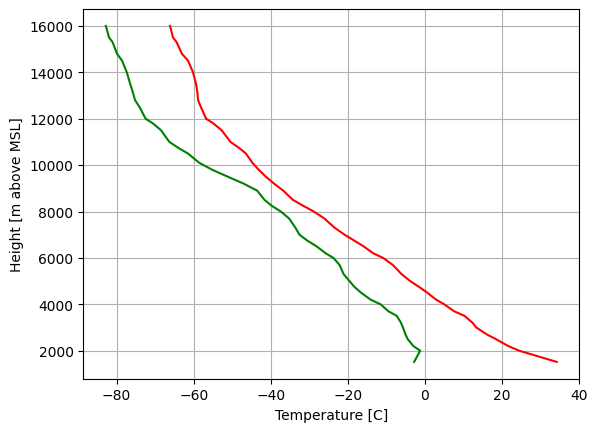

SURFACE HEIGHT (m MSL): 1516.0
SURFACE HEIGHT (m AGL): 0.0
SURFACE HEIGHT (m MSL): 1516.0


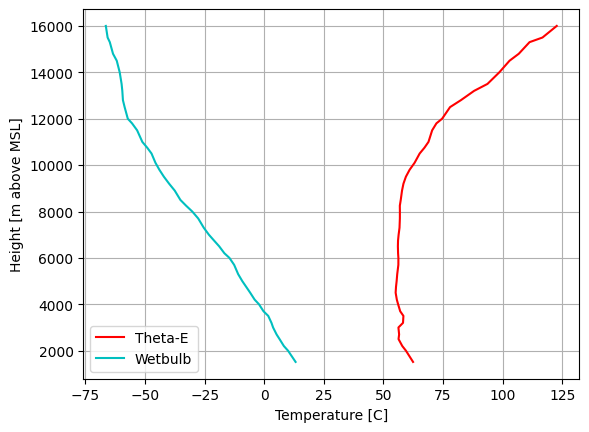

Most-Unstable CAPE: 214.93
Surface-based CAPE: 214.93
Most-Unstable LCL: 4215.51
Most-Unstable LFC: 4684.0
Most-Unstable EL: 8397.66
Most-Unstable LI: 1.0
500-700 mb Lapse Rate: 8.32
670-850 mb Lapse Rate: 12.43
Maximum Lapse Rate: 9.17
MWPI: 6.5
TEI: 7.3
MWPI WGP (kt): 65.48


/data/home004/ken.pryor/.conda/envs/devel/lib/python3.9/site-packages/numpy/lib/function_base.py:1594: UserWarning: Warning: converting a masked element to nan.
  return interp_func(x, xp, fp, left, right)
/data/home004/ken.pryor/.conda/envs/devel/lib/python3.9/site-packages/SHARPpy-0+unknown-py3.9.egg/sharppy/sharptab/params.py:2275: RuntimeWarning: divide by zero encountered in double_scalars
  pcl.brn = pcl.bplus / pcl.brnshear


In [1]:
import sharppy
import sharppy.sharptab.profile as profile
import sharppy.sharptab.interp as interp
import sharppy.sharptab.winds as winds
import sharppy.sharptab.utils as utils
import sharppy.sharptab.params as params
import sharppy.sharptab.thermo as thermo

spc_file = open('NUCAPS_NPP_0701_2028.txt', 'r').read()

import numpy as np
from io import StringIO

def parseSPC(spc_file):
    """
        This function will read a SPC-style formatted observed sounding file,
        similar to that of the 14061619.OAX file included in the SHARPpy distribution.

        It will return the pressure, height, temperature, dewpoint, wind direction and wind speed data
        from that file.
    """
    ## read in the file
    data = np.array([l.strip() for l in spc_file.split('\n')])

    ## necessary index points
    title_idx = np.where( data == '%TITLE%')[0][0]
    start_idx = np.where( data == '%RAW%' )[0] + 1
    finish_idx = np.where( data == '%END%')[0]

    ## create the plot title
    data_header = data[title_idx + 1].split()
    location = data_header[0]
    time = data_header[1][:11]

    ## put it all together for StringIO
    full_data = '\n'.join(data[start_idx[0] : finish_idx[0]][:])
    sound_data = StringIO( full_data )

    ## read the data into arrays
    p, h, T, Td, wdir, wspd = np.genfromtxt( sound_data, delimiter=',', comments="%", unpack=True )

    return p, h, T, Td, wdir, wspd

pres, hght, tmpc, dwpc, wdir, wspd = parseSPC(spc_file)

prof = profile.create_profile(profile='default', pres=pres, hght=hght, tmpc=tmpc, \
                                    dwpc=dwpc, wspd=wspd, wdir=wdir, missing=-9999, strictQC=True)

import matplotlib.pyplot as plt
plt.plot(prof.tmpc, prof.hght, 'r-')
plt.plot(prof.dwpc, prof.hght, 'g-')
#plt.barbs(40*np.ones(len(prof.hght)), prof.hght, prof.u, prof.v)
plt.xlabel("Temperature [C]")
plt.ylabel("Height [m above MSL]")
plt.grid()
plt.show()

msl_hght = prof.hght[prof.sfc] # Grab the surface height value
print("SURFACE HEIGHT (m MSL):",msl_hght)
agl_hght = interp.to_agl(prof, msl_hght) # Converts to AGL
print("SURFACE HEIGHT (m AGL):", agl_hght)
msl_hght = interp.to_msl(prof, agl_hght) # Converts to MSL
print("SURFACE HEIGHT (m MSL):",msl_hght)

plt.plot(thermo.ktoc(prof.thetae), prof.hght, 'r-', label='Theta-E')
plt.plot(prof.wetbulb, prof.hght, 'c-', label='Wetbulb')
plt.xlabel("Temperature [C]")
plt.ylabel("Height [m above MSL]")
plt.legend()
plt.grid()
plt.show()

def lapse_rate(prof, lower, upper, pres=True):
    '''
        Calculates the lapse rate (C/km) from a profile object

        Parameters
        ----------
        prof : profile object
            Profile Object
        lower : number
            Lower Bound of lapse rate (mb or m AGL)
        upper : number
            Upper Bound of lapse rate (mb or m AGL)
        pres : bool (optional; default = True)
            Flag to determine if lower/upper are pressure [True]
            or height [False]

        Returns
        -------
        lapse rate (C/km) : number
        '''
    if pres:
        if (prof.pres[-1] > upper): return ma.masked
        p1 = lower
        p2 = upper
        z1 = interp.hght(prof, lower)
        z2 = interp.hght(prof, upper)
    else:
        z1 = interp.to_msl(prof, lower)
        z2 = interp.to_msl(prof, upper)
        p1 = interp.pres(prof, z1)
        p2 = interp.pres(prof, z2)
    tv1 = interp.vtmp(prof, p1)
    tv2 = interp.vtmp(prof, p2)
    return (tv2 - tv1) / (z2 - z1) * -1000.

def max_lapse_rate(prof, lower=2000, upper=6000, interval=250, depth=2000):
    '''
        Calculates the maximum lapse rate (C/km) between a layer at a specified interval

        Parameters
        ----------
        prof: profile object
            Profile object
        lower : number
            Lower bound in height (m)
        upper : number
            Upper bound in height (m)
        interval : number
            Interval to assess the lapse rate at (m)
        depth : number
            Depth of the layer to assess the lapse rate over (m)

        Returns
        -------
        max lapse rate (C/km) : float
        lower pressure of max lapse rate (mb) : number
        upper pressure of max lapse rate (mb) : number
    '''

    bottom_levels = interp.to_msl(prof, np.arange(lower, upper-depth+interval, interval))
    top_levels = interp.to_msl(prof, np.arange(lower+depth, upper+interval, interval))
    bottom_pres = interp.pres(prof, bottom_levels)
    top_pres = interp.pres(prof, top_levels)
    all_lapse_rates = (interp.vtmp(prof, top_pres) - interp.vtmp(prof, bottom_pres)) * -1000.
    max_lapse_rate_idx = np.ma.argmax(all_lapse_rates)
    return all_lapse_rates[max_lapse_rate_idx]/depth, bottom_pres[max_lapse_rate_idx], top_pres[max_lapse_rate_idx]

def mwpi(prof):
    '''
        Microburst Windspeed Potential Index (MWPI)

        Formulated by Kenneth Pryor NOAA/NESDIS/STAR
        
        The Microburst Windspeed Potential Index (MWPI) is designed to quantify the most relevant factors
        in convective downburst generation in intermediate thermodynamic environments by incorporating 1) surface-based
        CAPE, 2) the temperature lapse rate between the 670- and 850-mb levels, and 3) DDD between the 670- and
        850-mb levels. The MWPI formula consists of a set of predictor variables (i.e., dewpoint depression
        and temperature lapse rate) that generates output of the expected microburst risk. 
        Scaling factors of 1000 J/kg, 5 C/km, and 5 C, respectively, are applied to the MWPI algorithm
        to yield a unitless MWPI value that expresses wind gust potential on a scale from 1 to 5:

        MWPI = (CAPE/1000) + LR/5 + DDD/5 
        
        Reference:
        Pryor, K. L., 2015: Progress and Developments of Downburst Prediction Applications of GOES. Wea. Forecasting, 30, 1182–1200.
        
        Parameters
        ----------
        prof : Profile object

        Returns
        -------
        mwpi : number
            MWPI (unitless)
    '''
    sbpcl = getattr(prof, 'sfcpcl', params.parcelx(prof, flag=1))
    sb_cape = sbpcl.bplus
    
    mupcl = getattr(prof, 'mupcl', params.parcelx(prof, flag=1))
    mu_cape = mupcl.bplus
    lr_hi = lapse_rate(prof, 700, 500, pres=True)
    lr_lo = lapse_rate(prof, 850, 670, pres=True)
    sfc = prof.pres[prof.sfc]
    
    if lr_hi > lr_lo:
    #MWPI calculation for 500-700 mb layer
        lr700_500 = lapse_rate(prof, 700, 500, pres=True)
        t500 = interp.temp(prof, 500.)
        t700 = interp.temp(prof, 700.)
        td500 = interp.dwpt(prof, 500.)
        td700 = interp.dwpt(prof, 700.)
        dd500 = t500 - td500
        dd700 = t700 - td700
        ddd = dd700 - dd500
        if ddd < 0:
            ddd = 0
        mwpi = (mu_cape/1000) + (lr700_500/5) + (ddd/5)
    elif sfc < 850:
    #MWPI calculation for 500-700 mb layer
        lr700_500 = lapse_rate(prof, 700, 500, pres=True)
        t500 = interp.temp(prof, 500.)
        t700 = interp.temp(prof, 700.)
        td500 = interp.dwpt(prof, 500.)
        td700 = interp.dwpt(prof, 700.)
        dd500 = t500 - td500
        dd700 = t700 - td700
        ddd = dd700 - dd500
        if ddd < 0:
            ddd = 0
        mwpi = (mu_cape/1000) + (lr700_500/5) + (ddd/5)
    else:
    #MWPI calculation for surface-based mixed layer
        lr850_670 = lapse_rate(prof, 850, 670, pres=True)
        t670 = interp.temp(prof, 670.)
        t850 = interp.temp(prof, 850.)
        td670 = interp.dwpt(prof, 670.)
        td850 = interp.dwpt(prof, 850.)
        dd670 = t670 - td670
        dd850 = t850 - td850
        ddd = dd850 - dd670
        if ddd < 0:
            ddd = 0
        mwpi = (mu_cape/1000) + (lr850_670/5) + (ddd/5)    
    return mwpi

sfcpcl = params.parcelx( prof, flag=1 ) # Surface Parcel
fcstpcl = params.parcelx( prof, flag=2 ) # Forecast Parcel
mupcl = params.parcelx( prof, flag=3 ) # Most-Unstable Parcel
mlpcl = params.parcelx( prof, flag=4 ) # 100 mb Mean Layer Parcel
#mucape = str(mupcl.bplus)
mucape = str(round(mupcl.bplus,2))
print("Most-Unstable CAPE:", mucape) # J/kg
sbcape = str(round(sfcpcl.bplus,2))
#sbcape = str(sfcpcl.bplus)
print("Surface-based CAPE:", sbcape) # J/kg
lcl = round(mupcl.lclhght,2)
lfc = round(mupcl.lfchght,2)
el = round(mupcl.elhght,2)
li = str(round(mupcl.li5,2))
print("Most-Unstable LCL:", lcl) # meters AGL
print("Most-Unstable LFC:", lfc) # meters AGL
print("Most-Unstable EL:", el) # meters AGL
print("Most-Unstable LI:", li) # C
lr_hi = str(round(lapse_rate(prof, 700, 500, pres=True),2))
print("500-700 mb Lapse Rate:", lr_hi)
lr_lo = str(round(lapse_rate(prof, 850, 670, pres=True),2))
print("670-850 mb Lapse Rate:", lr_lo)
lapse_rate_max, bottom_pres, top_pres = max_lapse_rate(prof, lower=2000, upper=8000, interval=250, depth=2000)
lr_max = str(round(lapse_rate_max,2))
print("Maximum Lapse Rate:", lr_max)

mwi = mwpi(prof)
mwp = round(mwi,2)
mwp_str = str(mwp)
print("MWPI:", mwp_str) 
#t_tot = str(params.t_totals(prof))
#print("T Totals:", t_tot)
#k_idx = str(params.k_index(prof))
#print("K-index:", k_idx)
te_idx = str(round(params.tei(prof),2))
print("TEI:", te_idx)
#WGP = (0.35435365777 * ((params.mwpi(prof))**2)) + (1.2959855*(params.mwpi(prof))) + 33.8176788
WGP = (1.1 * (mwp**2)) + (-3.8*mwp) + 43.7
mwpi_gp = str(round(WGP,2))
print("MWPI WGP (kt):", mwpi_gp)

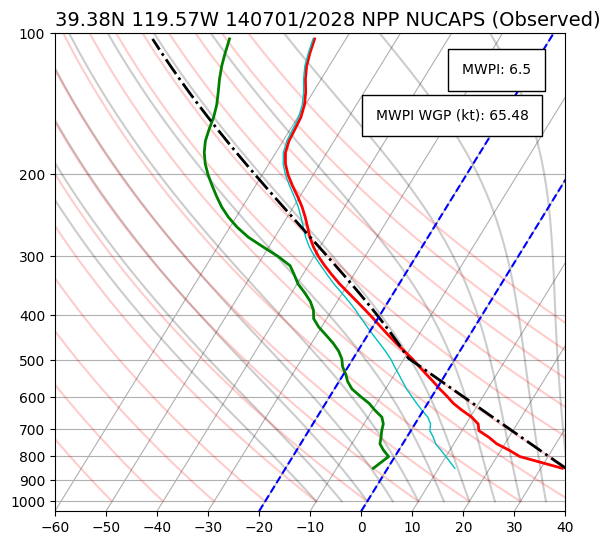

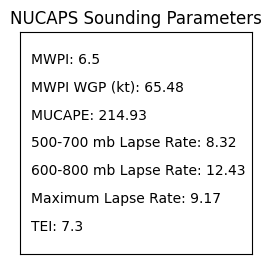

In [2]:
# Create a new figure. Plot a sounding emagram. The dimensions here give a good aspect ratio
import sharppy.plot.skew as skew
fig = plt.figure(figsize=(6.5875, 6.2125))
ax = fig.add_subplot(111, projection='skewx')
#ax = fig.add_subplot(111)
ax.grid(True)

# Select the Most-Unstable parcel (this can be changed)
pcl = mupcl

# Let's set the y-axis bounds of the plot.
pmax = 1000
pmin = 10
dp = -10
presvals = np.arange(int(pmax), int(pmin)+dp, dp)

# plot the moist-adiabats at surface temperatures -10 C to 45 C at 5 degree intervals.
for t in np.arange(-10,45,5):
    tw = []
    for p in presvals:
        tw.append(thermo.wetlift(1000., t, p))
    # Plot the moist-adiabat with a black line that is faded a bit.
    ax.semilogy(tw, presvals, 'k-', alpha=.2)

# A function to calculate the dry adiabats
def thetas(theta, presvals):
    return ((theta + thermo.ZEROCNK) / (np.power((1000. / presvals),thermo.ROCP))) - thermo.ZEROCNK

# plot the dry adiabats
for t in np.arange(-50,110,10):
    ax.semilogy(thetas(t, presvals), presvals, 'r-', alpha=.2)

# plot the title.
plt.title('39.38N 119.57W 140701/2028 NPP NUCAPS (Observed)', fontsize=14, loc='left')

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dicatated by the typical meteorological plot
ax.semilogy(prof.tmpc, prof.pres, 'r', lw=2)
ax.semilogy(prof.dwpc, prof.pres, 'g', lw=2)
ax.semilogy(prof.wetbulb, prof.pres, 'c-', lw=1)

# Plot the parcel trace.
ax.semilogy(pcl.ttrace, pcl.ptrace, 'k-.', lw=2)

# Denote the 0 to -20 C area on the Skew-T.
l = ax.axvline(0, color='b', linestyle='--')
l = ax.axvline(-20, color='b', linestyle='--')

# Set the log-scale formatting and label the y-axis tick marks.
ax.yaxis.set_major_formatter(plt.ScalarFormatter())
ax.set_yticks(np.linspace(100,1000,10))
ax.set_ylim(1050,100)

# Label the x-axis tick marks.
ax.xaxis.set_major_locator(plt.MultipleLocator(10))
ax.set_xlim(-60,40)
xticks = np.arange(-60, 41, 10)
ax.set_xticks(xticks)

ax.text(-20, 120, r'MWPI: '+mwp_str, size=10, ha='right', va='center', bbox={'facecolor': 'white', 'alpha': 1, 'pad': 10})
ax.text(-15, 150, r'MWPI WGP (kt): '+mwpi_gp, size=10, ha='right', va='center', bbox={'facecolor': 'white', 'alpha': 1, 'pad': 10})
# Show the plot to the user.
plt.savefig('skewt_npp_nucaps_0701_2028.png', bbox_inches='tight') # saves the plot to the disk.
plt.show()

fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot()
fig.subplots_adjust(top=0.85)

# Set titles for the figure and the subplot respectively
ax.set_title('NUCAPS Sounding Parameters')
#ax.set_xlabel('xlabel')
#ax.set_ylabel('ylabel')

# Set both x- and y-axis limits to [0, 10] instead of default [0, 1]
ax.axis([0, 10, 0, 8])
ax.text(0.5, 7, r'MWPI: '+mwp_str, size=10, ha='left', va='center')
ax.text(0.5, 6, r'MWPI WGP (kt): '+mwpi_gp, size=10, ha='left', va='center')
ax.text(0.5, 5, r'MUCAPE: '+mucape, size=10, ha='left', va='center')
ax.text(0.5, 4, r'500-700 mb Lapse Rate: '+lr_hi, size=10, ha='left', va='center')
ax.text(0.5, 3, r'600-800 mb Lapse Rate: '+lr_lo, size=10, ha='left', va='center')
ax.text(0.5, 2, r'Maximum Lapse Rate: '+lr_max, size=10, ha='left', va='center')
ax.text(0.5, 1, r'TEI: '+te_idx, size=10, ha='left', va='center')

# Hide X and Y axes label marks
ax.xaxis.set_tick_params(labelbottom=False)
ax.yaxis.set_tick_params(labelleft=False)
# Hide X and Y axes tick marks
ax.set_xticks([])
ax.set_yticks([])
plt.savefig('skewt_npp_nucaps_0701_2028_param.png', bbox_inches='tight') # saves the plot to the disk.
plt.show()

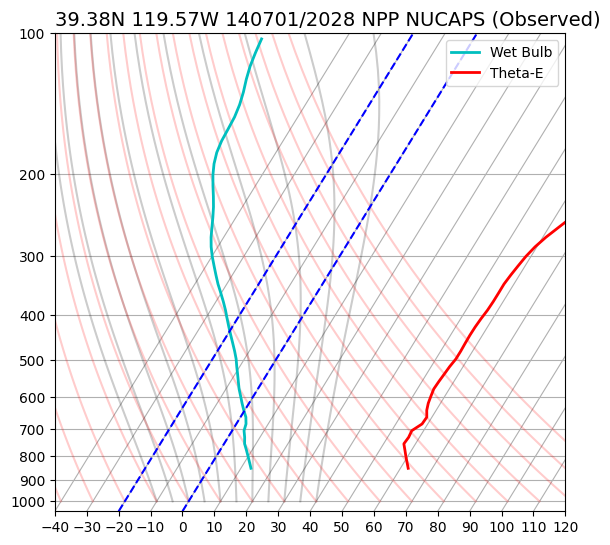

In [3]:
# Create a new figure. Plot a sounding emagram. The dimensions here give a good aspect ratio
import sharppy.plot.skew as skew
fig = plt.figure(figsize=(6.5875, 6.2125))
ax = fig.add_subplot(111, projection='skewx')
#ax = fig.add_subplot(111)
ax.grid(True)

# Select the Most-Unstable parcel (this can be changed)
pcl = mupcl

# Let's set the y-axis bounds of the plot.
pmax = 1000
pmin = 10
dp = -10
presvals = np.arange(int(pmax), int(pmin)+dp, dp)

# plot the moist-adiabats at surface temperatures -10 C to 45 C at 5 degree intervals.
for t in np.arange(-10,45,5):
    tw = []
    for p in presvals:
        tw.append(thermo.wetlift(1000., t, p))
    # Plot the moist-adiabat with a black line that is faded a bit.
    ax.semilogy(tw, presvals, 'k-', alpha=.2)

# A function to calculate the dry adiabats
def thetas(theta, presvals):
    return ((theta + thermo.ZEROCNK) / (np.power((1000. / presvals),thermo.ROCP))) - thermo.ZEROCNK

# plot the dry adiabats
for t in np.arange(-50,150,10):
    ax.semilogy(thetas(t, presvals), presvals, 'r-', alpha=.2)

# plot the title.
plt.title('39.38N 119.57W 140701/2028 NPP NUCAPS (Observed)', fontsize=14, loc='left')

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dicatated by the typical meteorological plot
ax.semilogy(prof.wetbulb, prof.pres, 'c', lw=2, label='Wet Bulb')
ax.semilogy(thermo.ktoc(prof.thetae), prof.pres, 'r', lw=2, label='Theta-E')

# Denote the 0 to -20 C area on the Skew-T.
l = ax.axvline(0, color='b', linestyle='--')
l = ax.axvline(-20, color='b', linestyle='--')

# Set the log-scale formatting and label the y-axis tick marks.
ax.yaxis.set_major_formatter(plt.ScalarFormatter())
ax.set_yticks(np.linspace(100,1000,10))
ax.set_ylim(1050,100)

# Label the x-axis tick marks.
ax.xaxis.set_major_locator(plt.MultipleLocator(10))
ax.set_xlim(-40,120)
xticks = np.arange(-40, 121, 10)
ax.set_xticks(xticks)

# Show the plot to the user.
plt.legend()
plt.savefig('skewt_npp_nucaps_0701_2028_wbte.png', bbox_inches='tight') # saves the plot to the disk.
plt.show()

[[  100.     115.     135.     150.     200.     250.     300.     350.
    400.     430.     475.     500.     570.     620.     670.     700.
    780.     850.  ]
 [  207.68   208.86   210.51   211.8    223.2    228.84   234.83   243.25
    251.06   255.39   261.47   264.69   273.45   279.6    285.56   288.92
    295.79   299.59]
 [  192.94   197.2    198.54   199.48   208.42   222.64   231.88   236.77
    243.53   247.07   253.99   257.31   262.08   264.1    265.58   266.32
    268.11   271.68]
 [16702.   15850.   14865.   14213.   12381.   10903.    9665.    8586.
   7619.    7082.    6328.    5932.    4898.    4216.    3573.    3204.
   2275.    1524.  ]]
[850. 780. 700. 670. 620. 570. 500. 475. 430. 400. 350. 300. 250. 200.
 150. 135. 115. 100.]
[ 1524.  2275.  3204.  3573.  4216.  4898.  5932.  6328.  7082.  7619.
  8586.  9665. 10903. 12381. 14213. 14865. 15850. 16702.]
[299.59 295.79 288.92 285.56 279.6  273.45 264.69 261.47 255.39 251.06
 243.25 234.83 228.84 223.2  211.8  21

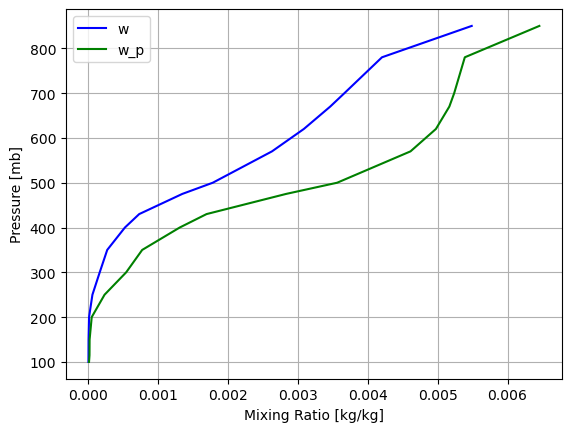

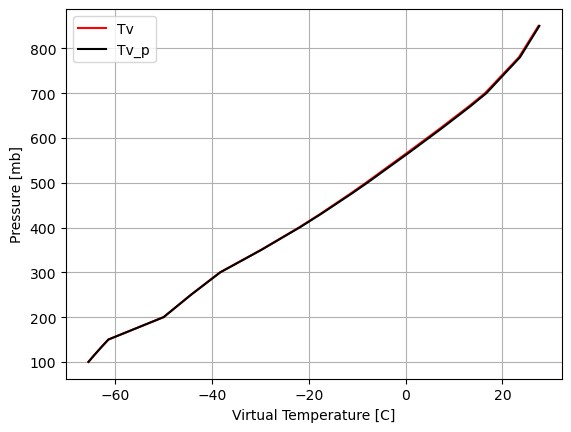

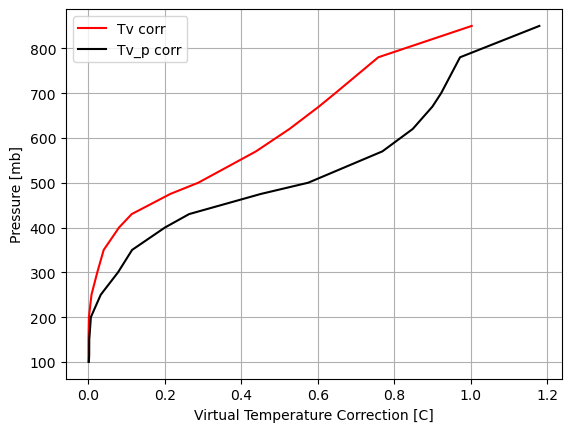

PUP idx =  (array([3], dtype=int64),)
PLO idx =  (array([0], dtype=int64),)

Gamma =  [6.847242]
Conditional Instability
Theta-e Gamma =  [1.2325141]
Tv Gamma =  [7.0423517]
Wetbulb Gamma =  [3.9125478]

MWPI =  [3.1071572]
MWPI WGP (kt) =  [42.512672]

MWPI from Virtual Temperature:
MWPI =  [3.2261353]
MWPI WGP (kt) =  [42.512672]
{'hght': array([ 1524.,  2275.,  3204.,  3573.,  4216.,  4898.,  5932.,  6328.,
        7082.,  7619.,  8586.,  9665., 10903., 12381., 14213., 14865.,
       15850., 16702.], dtype=float32), 'pres': array([850., 780., 700., 670., 620., 570., 500., 475., 430., 400., 350.,
       300., 250., 200., 150., 135., 115., 100.], dtype=float32), 'temp': array([ 26.440002 ,  22.640015 ,  15.77002  ,  12.410004 ,   6.450012 ,
         0.3000183,  -8.459991 , -11.679993 , -17.759995 , -22.089996 ,
       -29.899994 , -38.319992 , -44.309998 , -49.949997 , -61.34999  ,
       -62.64     , -64.28999  , -65.47     ], dtype=float32), 'dwpt': array([ -1.4700012,  -5.0400085, 

In [9]:
from __future__ import division
import matplotlib.pyplot as plt
import numpy as np
import math
from six import StringIO
from six import BytesIO
import pandas as pd

'''
GOES-15 Profile at 2014-07-01 22:08 UTC 
Retrieval Location: Lat: 39.56N Lon: 119.78W
'''

nucaps_prof = "goes_2208_data.txt"
prof_data = np.loadtxt(nucaps_prof, usecols=range(0, 4), dtype='f', unpack=True)
print(prof_data)
pressure_mb = np.flip(prof_data[0,:])
print(pressure_mb)
height_m = np.flip(prof_data[3,:])
print(height_m)
temperature_k = np.flip(prof_data[1,:])
print(temperature_k)
temperature_c = temperature_k - 273.15
print(temperature_c)
dewpoint_k = np.flip(prof_data[2,:])
print(dewpoint_k)
height_km = height_m/1000
print(height_km,len(height_km))

dewpoint_c = dewpoint_k - 273.15
RH = 100*(np.exp((17.625*dewpoint_c)/(243.04+dewpoint_c))/np.exp((17.625*temperature_c)/(243.04+temperature_c)))
print("RH: ", RH)
thetae = (273.15 + temperature_c)*((1000/pressure_mb)**0.286)+(3 * (RH * (3.884266 * 10**
         ((7.5 * temperature_c)/(237.7 + temperature_c)))/100))
wetbulb = temperature_c*(np.arctan(0.151977*((RH+8.313659)**0.5))) + (np.arctan(temperature_c+RH)) - (np.arctan(RH-1.676331))+((0.00391838*(RH**1.5))*(np.arctan(0.023101*RH))) - 4.686035
WBD = temperature_c - wetbulb
"""
Approximation for saturation mixing ratio and mixing ratio formulas are derived from Wallace and Hobbs (2006) equation 3.63 and Texas Instruments
Application Brief (2023) SNAA368 equations 1 and 4. Therefore, mixing ratio (mixrat) is approximately equal (or proportional) to e/p, where p is a 
reference pressure of 1000 mb. The virtual temperature difference between mixing ratio calculated with pressure 1000 mb and mixing ratio calculated 
with variable pressure (vs height) is negligible, especially in the boundary layer.
"""
satmixrat = (6.11*(10**((7.5*temperature_c)/(237.7+temperature_c))))/1000
print("Sat_mix_ratio = ",satmixrat)
mixrat = (6.11*(10**((7.5*dewpoint_c)/(237.7+dewpoint_c))))/1000
print("Mix_ratio = ",mixrat)
mixrat_p = (6.11*(10**((7.5*dewpoint_c)/(237.7+dewpoint_c))))/pressure_mb
print("Mix_ratio vs pressure (mb) = ",mixrat_p)
thetaw = thetae - (L_vapor*mixrat)
temperature_k = temperature_c + 273.15
"""
Approximation for virtual temperature (tempvirt) is derived from Wallace and Hobbs (2006) equation 3.60.
"""
tempvirt = temperature_k*(1+(0.61*(mixrat)))
tempvirt_c = tempvirt - 273.15
print("Virtual Temperature (C) = ",tempvirt_c)
tempvirt_exc = tempvirt_c - temperature_c

tempvirt_p = temperature_k*(1+(0.61*(mixrat_p)))
tempvirt_pc = tempvirt_p - 273.15
print("Virtual Temperature vs pressure (C) = ",tempvirt_pc)
tempvirt_exc_p = tempvirt_pc - temperature_c

import matplotlib.pyplot as plt
plt.plot(mixrat, pressure_mb, 'b-', label='w')
plt.plot(mixrat_p, pressure_mb, 'g-', label='w_p')
plt.xlabel("Mixing Ratio [kg/kg]")
plt.ylabel("Pressure [mb]")
plt.legend()
plt.grid()
plt.show()

plt.plot(tempvirt_c, pressure_mb, 'r-', label='Tv')
plt.plot(tempvirt_pc, pressure_mb, 'k-', label='Tv_p')
plt.xlabel("Virtual Temperature [C]")
plt.ylabel("Pressure [mb]")
plt.legend()
plt.grid()
plt.show()

plt.plot(tempvirt_exc, pressure_mb, 'r-', label='Tv corr')
plt.plot(tempvirt_exc_p, pressure_mb, 'k-', label='Tv_p corr')
plt.xlabel("Virtual Temperature Correction [C]")
plt.ylabel("Pressure [mb]")
plt.legend()
plt.grid()
plt.show()

idx_pup = np.where(pressure_mb == 670.0)
idx_plo = np.where(pressure_mb == 850.0)
print("PUP idx = ", idx_pup)
print("PLO idx = ", idx_plo)
Z_upper = height_km[idx_pup]
Z_lower = height_km[idx_plo]
T_sfc = temperature_k[idx_plo]
T_top = temperature_k[idx_pup]
Te_sfc = thetae[idx_plo]
Te_top = thetae[idx_pup]
Tv_sfc = tempvirt_c[idx_plo]
Tv_top = tempvirt_c[idx_pup]
wetbulb_sfc = wetbulb[idx_plo]
wetbulb_top = wetbulb[idx_pup]
delta_z = 2049
delta_zkm = 2.049
gamma = (T_sfc - T_top)/(delta_zkm)
gamma_Te = (Te_sfc - Te_top)/(Z_lower - Z_upper)
gamma_Tv = (Tv_sfc - Tv_top)/(delta_zkm)
gamma_wb = (wetbulb_sfc - wetbulb_top)/(delta_zkm)

print("")
print("Gamma = ", gamma)
if gamma > 4.8 and gamma <= 9.8:
    print("Conditional Instability") 
elif gamma > 9.8:
    print("Absolute Instability")
print("Theta-e Gamma = ", gamma_Te)
if gamma_Te < 0:
    print("Theta-e lapse rate is negative: potential instability")    
print("Tv Gamma = ", gamma_Tv)
print("Wetbulb Gamma = ", gamma_wb)
if gamma_wb > 4.8:
    print("Potential Instability")    
P_level_upper = pressure_mb[idx_pup]
P_level_lower = pressure_mb[idx_plo]
Z_upper = height_km[idx_pup]
Z_lower = height_km[idx_plo]
T_upper = temperature_c[idx_pup]
T_lower = temperature_c[idx_plo]
Tv_upper = tempvirt_c[idx_pup]
Tv_lower = tempvirt_c[idx_plo]
TD_upper = dewpoint_c[idx_pup]
TD_lower = dewpoint_c[idx_plo]
CAPE = 151.71
 
def MWPI(P_level_upper, P_level_lower, Z_upper, Z_lower, T_upper, T_lower, TD_upper, TD_lower, CAPE):
        gamma = (T_lower - T_upper)/(Z_upper - Z_lower)
        DD_upper = T_upper - TD_upper
        DD_lower = T_lower - TD_lower
        DDD = DD_lower - DD_upper
        MWPI = (CAPE/1000) + (gamma/5) + (DDD/5)
        WGP = (1.1 * (MWPI**2)) + (-3.8*MWPI) + 43.7
        return MWPI, WGP    
MWPI, WGP  = MWPI(P_level_upper, P_level_lower, Z_upper, Z_lower, T_upper, T_lower, TD_upper, TD_lower, CAPE)    
print("")
print("MWPI = ", MWPI)
print("MWPI WGP (kt) = ", WGP)

def MWPI_Tv(P_level_upper, P_level_lower, Z_upper, Z_lower, Tv_upper, Tv_lower, TD_upper, TD_lower, CAPE):
        gamma = (Tv_lower - Tv_upper)/(Z_upper - Z_lower)
        DD_upper = Tv_upper - TD_upper
        DD_lower = Tv_lower - TD_lower
        DDD = DD_lower - DD_upper
        MWPI_Tv = (CAPE/1000) + (gamma/5) + (DDD/5)
        WGP_Tv = (1.1 * (MWPI**2)) + (-3.8*MWPI) + 43.7
        return MWPI_Tv, WGP_Tv
MWPI_Tv, WGP_Tv  = MWPI_Tv(P_level_upper, P_level_lower, Z_upper, Z_lower, Tv_upper, Tv_lower, TD_upper, TD_lower, CAPE)    
print("")
print("MWPI from Virtual Temperature:")
print("MWPI = ", MWPI_Tv)
print("MWPI WGP (kt) = ", WGP_Tv)

mydata=dict(zip(('hght','pres','temp','dwpt','thtae','wetbulb','depression','tempvirt','tempvirt_exc'),(height_m,pressure_mb,temperature_c,dewpoint_c,thetae,wetbulb,WBD,tempvirt_c,tempvirt_exc)))
print(mydata)
df_ret = pd.DataFrame.from_dict(mydata)
print(df_ret)
wdir = []
wspd = []
wval = 0
data_len = len(df_ret)
print("DF Length = ", data_len)
for i in range(data_len):
    wdir.append(wval)
    wspd.append(wval)
print("wdir, wspd: ", wdir, wspd)
data_sharppy=dict(zip(('pres','hght','temp','dwpt'),(pressure_mb, height_m, temperature_c, dewpoint_c)))
print(data_sharppy)
df_sharppy = pd.DataFrame.from_dict(data_sharppy)
print(df_sharppy)
df_sharppy = df_sharppy[['pres', 'hght', 'temp', 'dwpt']]
print(df_sharppy)
df_sharppy_wind =df_sharppy.assign(wdir = wdir, wspd = wspd)
print(df_sharppy_wind)
print("")
print("Sharppy formatted retrieval: ")
print("")
print(df_sharppy_wind.to_string(header=False, index=False, formatters={"pres": "  {:.2f},  ".format, "hght": "{:.2f},  ".format,
                                                                       "temp": "{:.2f},  ".format, "dwpt": "{:.2f},  ".format,
                                                                       "wdir": "{:.2f},  ".format, "wspd": "{:.2f} ".format}))
print("")
print("Sounding profile with virtual temperature")
print("")
data_sharppy=dict(zip(('pres','hght','tempvirt','dwpt'),(pressure_mb, height_m, tempvirt_c, dewpoint_c)))
print(data_sharppy)
df_sharppy = pd.DataFrame.from_dict(data_sharppy)
print(df_sharppy)
df_sharppy = df_sharppy[['pres', 'hght', 'tempvirt', 'dwpt']]
print(df_sharppy)
df_sharppy_wind =df_sharppy.assign(wdir = wdir, wspd = wspd)
print(df_sharppy_wind)
print("")
print("Sharppy formatted retrieval: ")
print("")
print(df_sharppy_wind.to_string(header=False, index=False, formatters={"pres": "  {:.2f},  ".format, "hght": "{:.2f},  ".format,
                                                                       "tempvirt": "{:.2f},  ".format, "dwpt": "{:.2f},  ".format,
                                                                       "wdir": "{:.2f},  ".format, "wspd": "{:.2f} ".format}))
print("")

mydata=dict(zip(('hght','pres','temp','dwpt','thtae','wetbulb','depression','tempvirt','tempvirt_exc'),(height_m,pressure_mb,temperature_c,dewpoint_c,thetae,wetbulb,WBD,tempvirt_c,tempvirt_exc)))
print(mydata)
df_ret = pd.DataFrame.from_dict(mydata)
print(df_ret)
wdir = []
wspd = []
wval = -9999.00
data_len = len(df_ret)
print("DF Length = ", data_len)
for i in range(data_len):
    wdir.append(wval)
    wspd.append(wval)
print("wdir, wspd: ", wdir, wspd)
data_sharppy=dict(zip(('pres','hght','temp','dwpt'),(pressure_mb, height_m, temperature_c, dewpoint_c)))
print(data_sharppy)
df_sharppy = pd.DataFrame.from_dict(data_sharppy)
print(df_sharppy)
df_sharppy = df_sharppy[['pres', 'hght', 'temp', 'dwpt']]
print(df_sharppy)
df_sharppy_wind =df_sharppy.assign(wdir = wdir, wspd = wspd)
print(df_sharppy_wind)
print("")
print("Sharppy formatted retrieval: ")
print("")
print(df_sharppy_wind.to_string(header=False, index=False, formatters={"pres": "  {:.2f},  ".format, "hght": "{:.2f},  ".format,
                                                                       "temp": "{:.2f},  ".format, "dwpt": "{:.2f},  ".format,
                                                                       "wdir": "{:.2f},  ".format, "wspd": "{:.2f} ".format}))
print("")
print("Sounding profile with virtual temperature")
print("")
data_sharppy=dict(zip(('pres','hght','tempvirt','dwpt'),(pressure_mb, height_m, tempvirt_c, dewpoint_c)))
print(data_sharppy)
df_sharppy = pd.DataFrame.from_dict(data_sharppy)
print(df_sharppy)
df_sharppy = df_sharppy[['pres', 'hght', 'tempvirt', 'dwpt']]
print(df_sharppy)
df_sharppy_wind =df_sharppy.assign(wdir = wdir, wspd = wspd)
print(df_sharppy_wind)
print("")
print("Sharppy formatted retrieval: ")
print("")
print(df_sharppy_wind.to_string(header=False, index=False, formatters={"pres": "  {:.2f},  ".format, "hght": "{:.2f},  ".format,
                                                                       "tempvirt": "{:.2f},  ".format, "dwpt": "{:.2f},  ".format,
                                                                       "wdir": "{:.2f},  ".format, "wspd": "{:.2f} ".format}))
print("")

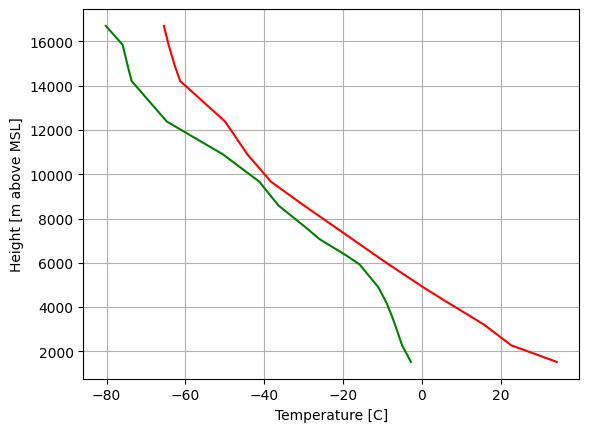

SURFACE HEIGHT (m MSL): 1524.0
SURFACE HEIGHT (m AGL): 0.0
SURFACE HEIGHT (m MSL): 1524.0


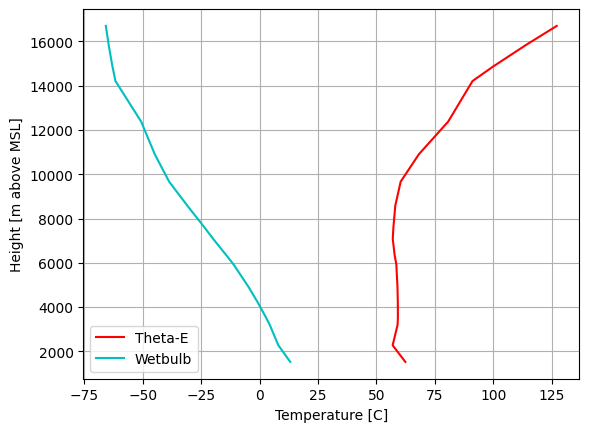

Most-Unstable CAPE: 151.71
Surface-based CAPE: 151.71
Most-Unstable LCL: 4491.8
Most-Unstable LFC: (4804.0, 2)
Most-Unstable EL: 8371.2
Most-Unstable LI: 0.62
500-700 mb Lapse Rate: 8.96
670-850 mb Lapse Rate: 10.69
Maximum Lapse Rate: 9.01
MWPI: 5.69
TEI: 5.45
MWPI WGP (kt): 57.69


In [4]:
import sharppy
import sharppy.sharptab.profile as profile
import sharppy.sharptab.interp as interp
import sharppy.sharptab.winds as winds
import sharppy.sharptab.utils as utils
import sharppy.sharptab.params as params
import sharppy.sharptab.thermo as thermo

spc_file = open('GOES_0701_2208.txt', 'r').read()

import numpy as np
from io import StringIO

def parseSPC(spc_file):
    """
        This function will read a SPC-style formatted observed sounding file,
        similar to that of the 14061619.OAX file included in the SHARPpy distribution.

        It will return the pressure, height, temperature, dewpoint, wind direction and wind speed data
        from that file.
    """
    ## read in the file
    data = np.array([l.strip() for l in spc_file.split('\n')])

    ## necessary index points
    title_idx = np.where( data == '%TITLE%')[0][0]
    start_idx = np.where( data == '%RAW%' )[0] + 1
    finish_idx = np.where( data == '%END%')[0]

    ## create the plot title
    data_header = data[title_idx + 1].split()
    location = data_header[0]
    time = data_header[1][:11]

    ## put it all together for StringIO
    full_data = '\n'.join(data[start_idx[0] : finish_idx[0]][:])
    sound_data = StringIO( full_data )

    ## read the data into arrays
    p, h, T, Td, wdir, wspd = np.genfromtxt( sound_data, delimiter=',', comments="%", unpack=True )

    return p, h, T, Td, wdir, wspd

pres, hght, tmpc, dwpc, wdir, wspd = parseSPC(spc_file)

prof = profile.create_profile(profile='default', pres=pres, hght=hght, tmpc=tmpc, \
                                    dwpc=dwpc, wspd=wspd, wdir=wdir, missing=-9999, strictQC=True)

import matplotlib.pyplot as plt
plt.plot(prof.tmpc, prof.hght, 'r-')
plt.plot(prof.dwpc, prof.hght, 'g-')
#plt.barbs(40*np.ones(len(prof.hght)), prof.hght, prof.u, prof.v)
plt.xlabel("Temperature [C]")
plt.ylabel("Height [m above MSL]")
plt.grid()
plt.show()

msl_hght = prof.hght[prof.sfc] # Grab the surface height value
print("SURFACE HEIGHT (m MSL):",msl_hght)
agl_hght = interp.to_agl(prof, msl_hght) # Converts to AGL
print("SURFACE HEIGHT (m AGL):", agl_hght)
msl_hght = interp.to_msl(prof, agl_hght) # Converts to MSL
print("SURFACE HEIGHT (m MSL):",msl_hght)

plt.plot(thermo.ktoc(prof.thetae), prof.hght, 'r-', label='Theta-E')
plt.plot(prof.wetbulb, prof.hght, 'c-', label='Wetbulb')
plt.xlabel("Temperature [C]")
plt.ylabel("Height [m above MSL]")
plt.legend()
plt.grid()
plt.show()

def lapse_rate(prof, lower, upper, pres=True):
    '''
        Calculates the lapse rate (C/km) from a profile object

        Parameters
        ----------
        prof : profile object
            Profile Object
        lower : number
            Lower Bound of lapse rate (mb or m AGL)
        upper : number
            Upper Bound of lapse rate (mb or m AGL)
        pres : bool (optional; default = True)
            Flag to determine if lower/upper are pressure [True]
            or height [False]

        Returns
        -------
        lapse rate (C/km) : number
        '''
    if pres:
        if (prof.pres[-1] > upper): return ma.masked
        p1 = lower
        p2 = upper
        z1 = interp.hght(prof, lower)
        z2 = interp.hght(prof, upper)
    else:
        z1 = interp.to_msl(prof, lower)
        z2 = interp.to_msl(prof, upper)
        p1 = interp.pres(prof, z1)
        p2 = interp.pres(prof, z2)
    tv1 = interp.vtmp(prof, p1)
    tv2 = interp.vtmp(prof, p2)
    return (tv2 - tv1) / (z2 - z1) * -1000.

def max_lapse_rate(prof, lower=2000, upper=6000, interval=250, depth=2000):
    '''
        Calculates the maximum lapse rate (C/km) between a layer at a specified interval

        Parameters
        ----------
        prof: profile object
            Profile object
        lower : number
            Lower bound in height (m)
        upper : number
            Upper bound in height (m)
        interval : number
            Interval to assess the lapse rate at (m)
        depth : number
            Depth of the layer to assess the lapse rate over (m)

        Returns
        -------
        max lapse rate (C/km) : float
        lower pressure of max lapse rate (mb) : number
        upper pressure of max lapse rate (mb) : number
    '''

    bottom_levels = interp.to_msl(prof, np.arange(lower, upper-depth+interval, interval))
    top_levels = interp.to_msl(prof, np.arange(lower+depth, upper+interval, interval))
    bottom_pres = interp.pres(prof, bottom_levels)
    top_pres = interp.pres(prof, top_levels)
    all_lapse_rates = (interp.vtmp(prof, top_pres) - interp.vtmp(prof, bottom_pres)) * -1000.
    max_lapse_rate_idx = np.ma.argmax(all_lapse_rates)
    return all_lapse_rates[max_lapse_rate_idx]/depth, bottom_pres[max_lapse_rate_idx], top_pres[max_lapse_rate_idx]

def mwpi(prof):
    '''
        Microburst Windspeed Potential Index (MWPI)

        Formulated by Kenneth Pryor NOAA/NESDIS/STAR
        
        The Microburst Windspeed Potential Index (MWPI) is designed to quantify the most relevant factors
        in convective downburst generation in intermediate thermodynamic environments by incorporating 1) surface-based
        CAPE, 2) the temperature lapse rate between the 670- and 850-mb levels, and 3) DDD between the 670- and
        850-mb levels. The MWPI formula consists of a set of predictor variables (i.e., dewpoint depression
        and temperature lapse rate) that generates output of the expected microburst risk. 
        Scaling factors of 1000 J/kg, 5 C/km, and 5 C, respectively, are applied to the MWPI algorithm
        to yield a unitless MWPI value that expresses wind gust potential on a scale from 1 to 5:

        MWPI = (CAPE/1000) + LR/5 + DDD/5 
        
        Reference:
        Pryor, K. L., 2015: Progress and Developments of Downburst Prediction Applications of GOES. Wea. Forecasting, 30, 1182–1200.
        
        Parameters
        ----------
        prof : Profile object

        Returns
        -------
        mwpi : number
            MWPI (unitless)
    '''
    sbpcl = getattr(prof, 'sfcpcl', params.parcelx(prof, flag=1))
    sb_cape = sbpcl.bplus
    
    mupcl = getattr(prof, 'mupcl', params.parcelx(prof, flag=1))
    mu_cape = mupcl.bplus
    lr_hi = lapse_rate(prof, 700, 500, pres=True)
    lr_lo = lapse_rate(prof, 850, 670, pres=True)
    sfc = prof.pres[prof.sfc]
    
    if lr_hi > lr_lo:
    #MWPI calculation for 500-700 mb layer
        lr700_500 = lapse_rate(prof, 700, 500, pres=True)
        t500 = interp.temp(prof, 500.)
        t700 = interp.temp(prof, 700.)
        td500 = interp.dwpt(prof, 500.)
        td700 = interp.dwpt(prof, 700.)
        dd500 = t500 - td500
        dd700 = t700 - td700
        ddd = dd700 - dd500
        if ddd < 0:
            ddd = 0
        mwpi = (mu_cape/1000) + (lr700_500/5) + (ddd/5)
    elif sfc < 850:
    #MWPI calculation for 500-700 mb layer
        lr700_500 = lapse_rate(prof, 700, 500, pres=True)
        t500 = interp.temp(prof, 500.)
        t700 = interp.temp(prof, 700.)
        td500 = interp.dwpt(prof, 500.)
        td700 = interp.dwpt(prof, 700.)
        dd500 = t500 - td500
        dd700 = t700 - td700
        ddd = dd700 - dd500
        if ddd < 0:
            ddd = 0
        mwpi = (mu_cape/1000) + (lr700_500/5) + (ddd/5)
    else:
    #MWPI calculation for surface-based mixed layer
        lr850_670 = lapse_rate(prof, 850, 670, pres=True)
        t670 = interp.temp(prof, 670.)
        t850 = interp.temp(prof, 850.)
        td670 = interp.dwpt(prof, 670.)
        td850 = interp.dwpt(prof, 850.)
        dd670 = t670 - td670
        dd850 = t850 - td850
        ddd = dd850 - dd670
        if ddd < 0:
            ddd = 0
        mwpi = (mu_cape/1000) + (lr850_670/5) + (ddd/5)    
    return mwpi

sfcpcl = params.parcelx( prof, flag=1 ) # Surface Parcel
fcstpcl = params.parcelx( prof, flag=2 ) # Forecast Parcel
mupcl = params.parcelx( prof, flag=3 ) # Most-Unstable Parcel
mlpcl = params.parcelx( prof, flag=4 ) # 100 mb Mean Layer Parcel
#mucape = str(mupcl.bplus)
mucape = str(round(mupcl.bplus,2))
print("Most-Unstable CAPE:", mucape) # J/kg
sbcape = str(round(sfcpcl.bplus,2))
#sbcape = str(sfcpcl.bplus)
print("Surface-based CAPE:", sbcape) # J/kg
lcl = round(mupcl.lclhght,2)
lfc = (mupcl.lfchght,2)
el = round(mupcl.elhght,2)
li = str(round(mupcl.li5,2))
print("Most-Unstable LCL:", lcl) # meters AGL
print("Most-Unstable LFC:", lfc) # meters AGL
print("Most-Unstable EL:", el) # meters AGL
print("Most-Unstable LI:", li) # C
lr_hi = str(round(lapse_rate(prof, 700, 500, pres=True),2))
print("500-700 mb Lapse Rate:", lr_hi)
lr_lo = str(round(lapse_rate(prof, 850, 670, pres=True),2))
print("670-850 mb Lapse Rate:", lr_lo)
lapse_rate_max, bottom_pres, top_pres = max_lapse_rate(prof, lower=2000, upper=8000, interval=250, depth=2000)
lr_max = str(round(lapse_rate_max,2))
print("Maximum Lapse Rate:", lr_max)

mwi = mwpi(prof)
mwp = round(mwi,2)
mwp_str = str(mwp)
print("MWPI:", mwp_str) 
#t_tot = str(params.t_totals(prof))
#print("T Totals:", t_tot)
#k_idx = str(params.k_index(prof))
#print("K-index:", k_idx)
te_idx = str(round(params.tei(prof),2))
print("TEI:", te_idx)
WGP = (1.1 * (mwp**2)) + (-3.8*mwp) + 43.7
mwpi_gp = str(round(WGP,2))
print("MWPI WGP (kt):", mwpi_gp)

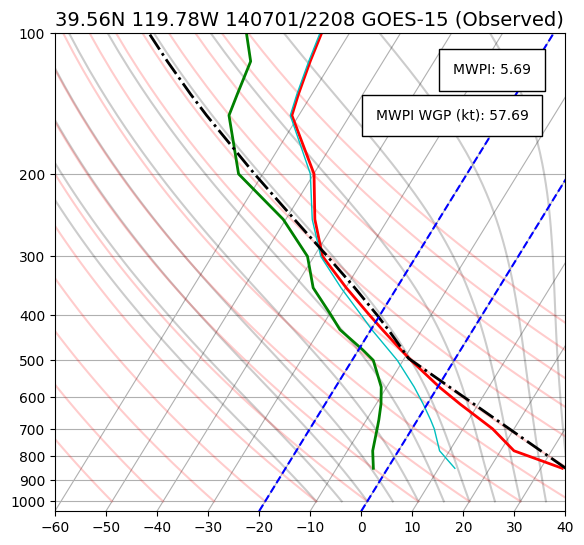

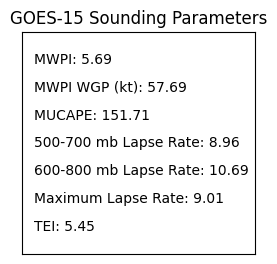

In [5]:
# Create a new figure. Plot a sounding emagram. The dimensions here give a good aspect ratio
import sharppy.plot.skew as skew
fig = plt.figure(figsize=(6.5875, 6.2125))
ax = fig.add_subplot(111, projection='skewx')
#ax = fig.add_subplot(111)
ax.grid(True)

# Select the Most-Unstable parcel (this can be changed)
pcl = mupcl

# Let's set the y-axis bounds of the plot.
pmax = 1000
pmin = 10
dp = -10
presvals = np.arange(int(pmax), int(pmin)+dp, dp)

# plot the moist-adiabats at surface temperatures -10 C to 45 C at 5 degree intervals.
for t in np.arange(-10,45,5):
    tw = []
    for p in presvals:
        tw.append(thermo.wetlift(1000., t, p))
    # Plot the moist-adiabat with a black line that is faded a bit.
    ax.semilogy(tw, presvals, 'k-', alpha=.2)

# A function to calculate the dry adiabats
def thetas(theta, presvals):
    return ((theta + thermo.ZEROCNK) / (np.power((1000. / presvals),thermo.ROCP))) - thermo.ZEROCNK

# plot the dry adiabats
for t in np.arange(-50,110,10):
    ax.semilogy(thetas(t, presvals), presvals, 'r-', alpha=.2)

# plot the title.
plt.title('39.56N 119.78W 140701/2208 GOES-15 (Observed)', fontsize=14, loc='left')

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dicatated by the typical meteorological plot
ax.semilogy(prof.tmpc, prof.pres, 'r', lw=2)
ax.semilogy(prof.dwpc, prof.pres, 'g', lw=2)
ax.semilogy(prof.wetbulb, prof.pres, 'c-', lw=1)

# Plot the parcel trace.
ax.semilogy(pcl.ttrace, pcl.ptrace, 'k-.', lw=2)

# Denote the 0 to -20 C area on the Skew-T.
l = ax.axvline(0, color='b', linestyle='--')
l = ax.axvline(-20, color='b', linestyle='--')

# Set the log-scale formatting and label the y-axis tick marks.
ax.yaxis.set_major_formatter(plt.ScalarFormatter())
ax.set_yticks(np.linspace(100,1000,10))
ax.set_ylim(1050,100)

# Label the x-axis tick marks.
ax.xaxis.set_major_locator(plt.MultipleLocator(10))
ax.set_xlim(-60,40)
xticks = np.arange(-60, 41, 10)
ax.set_xticks(xticks)

ax.text(-20, 120, r'MWPI: '+mwp_str, size=10, ha='right', va='center', bbox={'facecolor': 'white', 'alpha': 1, 'pad': 10})
ax.text(-15, 150, r'MWPI WGP (kt): '+mwpi_gp, size=10, ha='right', va='center', bbox={'facecolor': 'white', 'alpha': 1, 'pad': 10})
# Show the plot to the user.
plt.savefig('skewt_goes15_0701_2208.png', bbox_inches='tight') # saves the plot to the disk.
plt.show()

fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot()
fig.subplots_adjust(top=0.85)

# Set titles for the figure and the subplot respectively
ax.set_title('GOES-15 Sounding Parameters')
#ax.set_xlabel('xlabel')
#ax.set_ylabel('ylabel')

# Set both x- and y-axis limits to [0, 10] instead of default [0, 1]
ax.axis([0, 10, 0, 8])
ax.text(0.5, 7, r'MWPI: '+mwp_str, size=10, ha='left', va='center')
ax.text(0.5, 6, r'MWPI WGP (kt): '+mwpi_gp, size=10, ha='left', va='center')
ax.text(0.5, 5, r'MUCAPE: '+mucape, size=10, ha='left', va='center')
ax.text(0.5, 4, r'500-700 mb Lapse Rate: '+lr_hi, size=10, ha='left', va='center')
ax.text(0.5, 3, r'600-800 mb Lapse Rate: '+lr_lo, size=10, ha='left', va='center')
ax.text(0.5, 2, r'Maximum Lapse Rate: '+lr_max, size=10, ha='left', va='center')
ax.text(0.5, 1, r'TEI: '+te_idx, size=10, ha='left', va='center')

# Hide X and Y axes label marks
ax.xaxis.set_tick_params(labelbottom=False)
ax.yaxis.set_tick_params(labelleft=False)
# Hide X and Y axes tick marks
ax.set_xticks([])
ax.set_yticks([])
plt.savefig('skewt_goes15_0701_2208_param.png', bbox_inches='tight') # saves the plot to the disk.
plt.show()

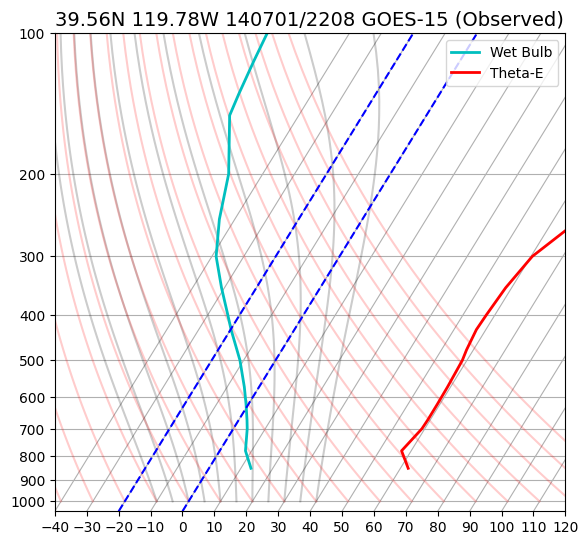

In [6]:
# Create a new figure. Plot a sounding emagram. The dimensions here give a good aspect ratio
import sharppy.plot.skew as skew
fig = plt.figure(figsize=(6.5875, 6.2125))
ax = fig.add_subplot(111, projection='skewx')
#ax = fig.add_subplot(111)
ax.grid(True)

# Select the Most-Unstable parcel (this can be changed)
pcl = mupcl

# Let's set the y-axis bounds of the plot.
pmax = 1000
pmin = 10
dp = -10
presvals = np.arange(int(pmax), int(pmin)+dp, dp)

# plot the moist-adiabats at surface temperatures -10 C to 45 C at 5 degree intervals.
for t in np.arange(-10,45,5):
    tw = []
    for p in presvals:
        tw.append(thermo.wetlift(1000., t, p))
    # Plot the moist-adiabat with a black line that is faded a bit.
    ax.semilogy(tw, presvals, 'k-', alpha=.2)

# A function to calculate the dry adiabats
def thetas(theta, presvals):
    return ((theta + thermo.ZEROCNK) / (np.power((1000. / presvals),thermo.ROCP))) - thermo.ZEROCNK

# plot the dry adiabats
for t in np.arange(-50,150,10):
    ax.semilogy(thetas(t, presvals), presvals, 'r-', alpha=.2)

# plot the title.
plt.title('39.56N 119.78W 140701/2208 GOES-15 (Observed)', fontsize=14, loc='left')

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dicatated by the typical meteorological plot
ax.semilogy(prof.wetbulb, prof.pres, 'c', lw=2, label='Wet Bulb')
ax.semilogy(thermo.ktoc(prof.thetae), prof.pres, 'r', lw=2, label='Theta-E')

# Denote the 0 to -20 C area on the Skew-T.
l = ax.axvline(0, color='b', linestyle='--')
l = ax.axvline(-20, color='b', linestyle='--')

# Set the log-scale formatting and label the y-axis tick marks.
ax.yaxis.set_major_formatter(plt.ScalarFormatter())
ax.set_yticks(np.linspace(100,1000,10))
ax.set_ylim(1050,100)

# Label the x-axis tick marks.
ax.xaxis.set_major_locator(plt.MultipleLocator(10))
ax.set_xlim(-40,120)
xticks = np.arange(-40, 121, 10)
ax.set_xticks(xticks)

# Show the plot to the user.
plt.legend()
plt.savefig('skewt_goes15_0701_2208_wbte.png', bbox_inches='tight') # saves the plot to the disk.
plt.show()